# 0e: extracts basin  precipitation seasonality of three-month rolling average precipitation and driest months

- creates `../data/additional_data/basin_past_pr_seasonality_3m_roll_lastm.csv`
    - precipitation seasonality of three-month rolling average precipitation for each basin from 1990 to 2019
- creates `../data/additional_data/basin_driest_months.csv`

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import oggm
import json
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon



In [7]:
xr.set_options(use_bottleneck=False)
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
#basin = 3425 #2309 #6243 #2103

In [ ]:
w5e5_path_pr = '/home/www/lschuster/w5e5v2.0/_script/pr_W5E5v2.0_*'
ds_pr = xr.open_mfdataset(w5e5_path_pr)
ds_pr = ds_pr.sel(time=slice('1989-11',str('2019-12'))) # want to have full consecutive months of three years
# create monthly seasonal statistics
ds_pr = ds_pr.resample(time='1M').mean()*60*60*24 # seconds to minutes to hours to days 
ds_pr = ds_pr.pr.load()
ds_pr_3m_sum = ds_pr.rolling(time=3, #center=True,
                             min_periods=3).sum().dropna(dim='time')
np.testing.assert_allclose(ds_pr_3m_sum.isel(time=0), 
                           ds_pr.isel(time=np.array([0,1,2])).sum(dim='time'))
assert ds_pr_3m_sum.isel(time=0).time.values == ds_pr.isel(time=2).time.values # # last month of the three consecutive months
assert len(ds_pr_3m_sum.time) == 360



### get basin shape and extract precipitation data from entire basin

In [9]:
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
basin_avg_pr_seasonal_dict = {}
basin_avg_pr_seasonal_l = []
for basin in pd_basin_num['MRBID'].values:
    # Define the polygon or multipolygon geometry
    polygon_geometry = pd_basin_num[pd_basin_num['MRBID'] == basin]['geometry'].values[0]
    ## 
    lat, lon = ds_pr_3m_sum.isel(time=0).to_dataframe().reset_index()['lat'].values, ds_pr_3m_sum.isel(time=0).to_dataframe().reset_index()['lon'].values
    # Check which points (lon, lat) are within the polygon
    points_within_polygon = []
    for y, x in zip(lat.flatten(), lon.flatten()):
        point = Point(x, y)
        if polygon_geometry.contains(point):
            points_within_polygon.append((y, x))

    # Extract data within the polygon_geometry from xarray
    if points_within_polygon:
        lats, lons = zip(*points_within_polygon)
        selected_data = ds_pr_3m_sum.sel(lat=lats, lon=lons)
        #print(selected_data)
    else:
        print("No points within the polygon.", basin, pd_basin_num[pd_basin_num['MRBID'] == basin]['RIVER_BASI'])


    weight = np.cos(np.deg2rad(selected_data.lat))
    weight = weight / weight.sum()
    basin_avg_pr_seasonal = (selected_data.mean(dim='lon') * weight).sum(dim='lat')

    basin_avg_pr_seasonal.coords['month'] = basin_avg_pr_seasonal['time.month']
    basin_avg_pr_seasonal.coords['year'] = basin_avg_pr_seasonal['time.year']

    df_basin_avg_pr_seasonal = basin_avg_pr_seasonal.to_dataframe('pr_3m_sum')
    basin_avg_pr_seasonal = df_basin_avg_pr_seasonal.groupby(['month','year']).sum().to_xarray()
    _pd_save = basin_avg_pr_seasonal.mean(dim='year').to_dataframe().reset_index()
    _pd_save['basin'] = basin
    basin_avg_pr_seasonal_dict[basin] = basin_avg_pr_seasonal.mean(dim='year')
    basin_avg_pr_seasonal_l.append(_pd_save)
    last_month_3m_driest_mean = basin_avg_pr_seasonal.mean(dim='year').idxmin(dim='month')['pr_3m_sum'].values.astype(int)
    pd_basin_num.loc[pd_basin_num.MRBID==basin,'last_3m_driest_month_seasonal_avg'] = last_month_3m_driest_mean

    ### just another approach, where instead the period is chosen that is most often driest (by checking the amount of years where it is driest) 
    # approach to first compute for each year the month and then use the "mode" to estimate the month
    # this could be problematic if there are two months that equally often occur
    last_month_3m_driest_stats = basin_avg_pr_seasonal.idxmin(dim='month')
    last_month_3m_driest = last_month_3m_driest_stats.pr_3m_sum.to_series().mode().values.astype(int)
    if len(last_month_3m_driest) >1:
        last_month_3m_driest = last_month_3m_driest[0]
    pd_basin_num.loc[pd_basin_num.MRBID==basin,'last_3m_driest_most_frequent_month'] = last_month_3m_driest
    yrs_w_selected_month = len(last_month_3m_driest_stats.where(last_month_3m_driest_stats.pr_3m_sum==last_month_3m_driest).dropna(dim='year').year)
    # how often is that one selected ??? 
    pd_basin_num.loc[pd_basin_num.MRBID==basin,'perc_yrs_w_last_3m_driest_most_frequent_month'] = 100*yrs_w_selected_month/len(last_month_3m_driest_stats.year)
pd.concat(basin_avg_pr_seasonal_l).reset_index().to_csv('../data/additional_data/basin_past_pr_seasonality_3m_roll_lastm.csv')
### but at the end decided to use the simpler "last_3m_driest_month_seasonal_avg" appraoch anyways

No points within the polygon. 3403 26    AZOPARDO
Name: RIVER_BASI, dtype: object


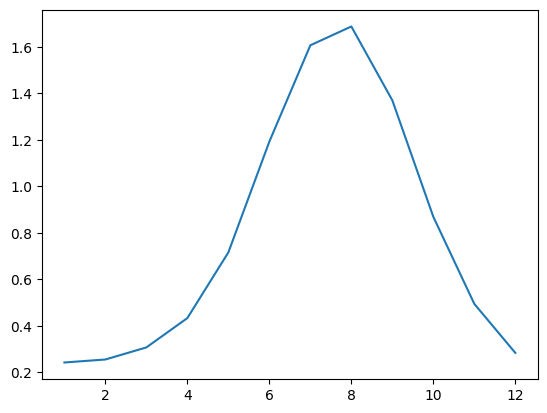

In [11]:
plt.plot(basin_avg_pr_seasonal_dict[2914].month,basin_avg_pr_seasonal_dict[2914].pr_3m_sum) # TARIM HE

In [16]:
pd_basin_num.columns

Index(['MRBID', 'RIVER_BASI', 'CONTINENT', 'OCEAN', 'SEA', 'AREA_CALC',
       'Shape_Leng', 'Shape_Area', 'RGI_AREA', 'geometry',
       'last_3m_driest_month_seasonal_avg',
       'last_3m_driest_most_frequent_month',
       'perc_yrs_w_last_3m_driest_most_frequent_month'],
      dtype='object')

In [17]:
pd.concat(basin_avg_pr_seasonal_l).reset_index()

,index,month,pr_3m_sum,basin
0,0,1,1.408089,2103
1,1,2,1.127565,2103
2,2,3,1.001359,2103
3,3,4,0.944727,2103
4,4,5,1.193606,2103
...,...,...,...,...
895,7,8,6.958698,6255
896,8,9,6.658634,6255
897,9,10,5.753815,6255
898,10,11,5.143767,6255


In [12]:
pd_basin_num.to_csv('../data/additional_data/basin_driest_months.csv')

#### in four basins the month is sifnificantly different between the approaches ...
*(and AZOPARDO does not have any W5E5 in the polygon, but that does not matter, as that basin is quite small ...*

Text(0.5, 0, 'last_3m_driest_most_frequent_month')

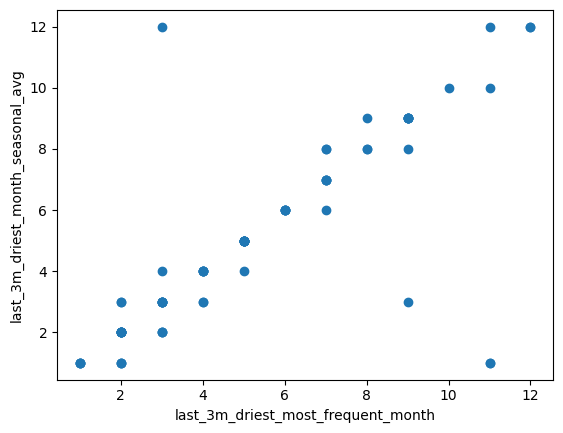

In [381]:
plt.plot(pd_basin_num['last_3m_driest_month_seasonal_avg'], pd_basin_num['last_3m_driest_most_frequent_month'], 'o')
plt.ylabel('last_3m_driest_month_seasonal_avg')
plt.xlabel('last_3m_driest_most_frequent_month')

In [354]:
pd_basin_num.where(np.abs(pd_basin_num['last_3m_driest_month_seasonal_avg']-pd_basin_num['last_3m_driest_most_frequent_month'])>1).dropna()

,MRBID,RIVER_BASI,CONTINENT,OCEAN,SEA,AREA_CALC,Shape_Leng,Shape_Area,RGI_AREA,geometry,last_3m_driest_month_seasonal_avg,last_3m_driest_most_frequent_month,perc_yrs_w_last_3m_driest_most_frequent_month
20,3209.0,CHICO,South America,Atlantic Ocean,South Atlantic,31904.0,15.906289,3.938502,33.841,"POLYGON ((-71.85833 -47.71250, -71.85777 -47.7...",11.0,1.0,16.666667
24,3244.0,SANTA CRUZ,South America,Atlantic Ocean,South Atlantic,28901.6,16.237999,3.635359,3011.749,"POLYGON ((-72.36250 -49.34583, -72.36250 -49.3...",11.0,1.0,23.333333
35,3420.0,PASCUA,South America,Pacific Ocean,South Pacific,14019.6,10.324566,1.715085,2437.533,"POLYGON ((-72.17048 -47.56079, -72.16458 -47.5...",3.0,12.0,26.666667
67,6223.0,KUBAN,Europe,Atlantic Ocean,Black Sea,52441.2,17.116922,5.942039,175.577,"POLYGON ((41.08750 45.41250, 41.08843 45.40926...",9.0,3.0,20.000000


- ok, but none of these are the selected basins. And, we do not focus in this manuscript on the dry-melt months of all basins...

Text(0.5, 0, 'month')

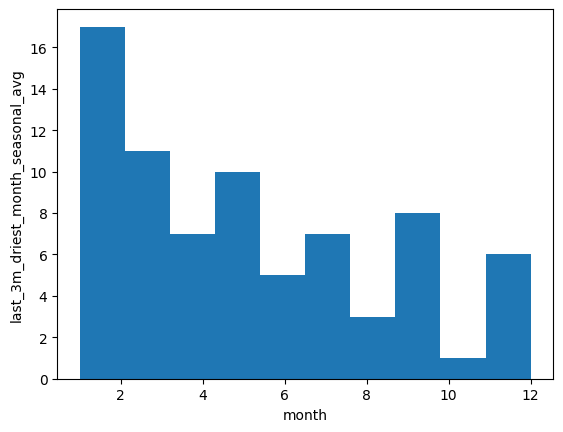

In [383]:
plt.hist(pd_basin_num['last_3m_driest_month_seasonal_avg'])
plt.ylabel('last_3m_driest_month_seasonal_avg')
plt.xlabel('month')

(array([20., 11.,  7.,  9.,  6.,  4.,  5.,  7.,  2.,  4.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

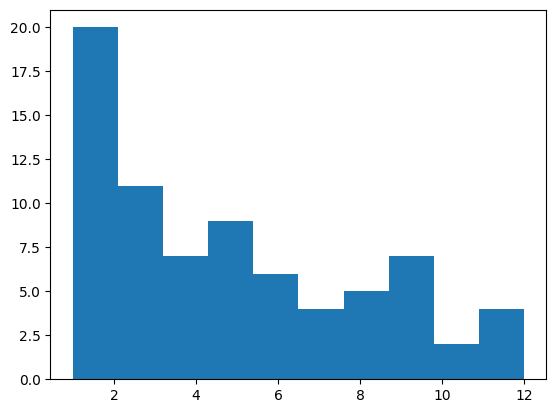

In [350]:
plt.hist(pd_basin_num['last_3m_driest_most_frequent_month'])

**Get the driest months of individual glaciers**

In [13]:
### *test, where possible*
df_rgi6g = pd.read_hdf(oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))

#### these are just the driest months but not the driest melt omnths --> what we acutally want is the driest melt months!!!
sel_rgi_ids = ['RGI60-11.01450',
           'RGI60-13.54431',  #largest glacier in RGI13
           'RGI60-16.01251', # largest glacier in RGI16 ADDED
           'RGI60-01.13696', # largest glacier in RGI01 ADDED 
           'RGI60-03.01710',  # largest glacier in RGi03
           'RGI60-04.06187',
           'RGI60-15.11693',
           'RGI60-11.00897']

for r in sel_rgi_ids:
    lon, lat = df_rgi6g.loc[r]['CenLon'], df_rgi6g.loc[r]['CenLat']
    rgi_id_pr_sel = ds_pr_3m_sum.sel(lon=lon, lat = lat, method='nearest')
    rgi_id_pr_sel.coords['month'] = rgi_id_pr_sel['time.month']
    rgi_id_pr_sel.coords['year'] = rgi_id_pr_sel['time.year']
    df_rgi_id_pr_sel = rgi_id_pr_sel.to_dataframe('pr_3m_sum')

    rgi_id_pr_sel = df_rgi_id_pr_sel.groupby(['month','year']).sum().to_xarray()
    #rgi_id_pr_sel = rgi_id_pr_sel.mean(dim='year')
    last_month_3m_driest_mean = rgi_id_pr_sel.mean(dim='year').idxmin(dim='month')['pr_3m_sum'].values.astype(int)

    print(r, last_month_3m_driest_mean)
    
    
for r in sel_rgi_ids:
    for b in pd_basin_num.MRBID:
        f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
        basin_rgis = json.load(f)[str(b)]
        if r in basin_rgis:
            print(r,b)
            print(pd_basin_num.loc[pd_basin_num.MRBID ==b]['last_3m_driest_month_seasonal_avg'].values)

RGI60-11.01450 9
RGI60-13.54431 9
RGI60-16.01251 9
RGI60-01.13696 7
RGI60-03.01710 3
RGI60-04.06187 3
RGI60-15.11693 1
RGI60-11.00897 3
RGI60-11.01450 6243
[8.]
RGI60-13.54431 2902
[9.]
RGI60-16.01251 3203
[9.]
RGI60-15.11693 2302
[1.]
RGI60-11.00897 6202
[3.]


**Quick check of precipitation cycle for selected basins**

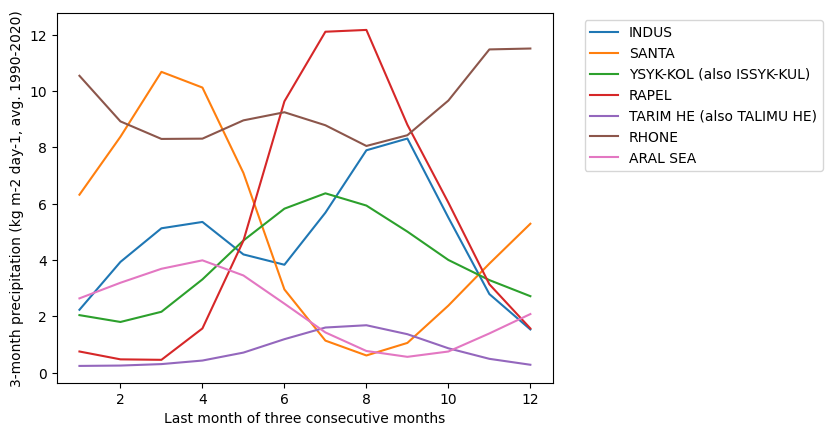

In [14]:
for basin in ['INDUS', 'SANTA', 'YSYK-KOL (also ISSYK-KUL)', 'RAPEL',
              'TARIM HE (also TALIMU HE)', 'RHONE', 'ARAL SEA']:
    basin_id=pd_basin_num.loc[pd_basin_num.RIVER_BASI==basin]['MRBID'].values[0]
    plt.plot(basin_avg_pr_seasonal_dict[basin_id].month,
             basin_avg_pr_seasonal_dict[basin_id].pr_3m_sum,
            label=basin) # TARIM HE
    #plt.title(basin)
    plt.xlabel('Last month of three consecutive months')
    plt.ylabel('3-month precipitation (kg m-2 day-1, avg. 1990-2020)')
plt.legend(ncol=1, loc = 'upper left', bbox_to_anchor=(1.05,1))